# Travel time analysis

## Background
A dataset of ~14.3 million records was provided containing details of Lyft trips. These records contained coordinats of start and end location along with the start time of the trip. Trip duration (in seconds) was provided for ~12.9 million records (the training set). The remaining 1.3 million records did not contain trip duration and it is desired to predict duration for these records (the test set).

## Methods

### Features
The features available in the training and test dataset could be divided into location features (represented by longitude & latitude coordinates for start and end locations) and time features (represented by the timestamp of the trip start time). These features were explored to determine their characteristics. 

For the location features, precision was reduced to use a neighborhood of 100m around the original location to be able to generalize from this data to new locations in the same neighborhoods. `Haversine distance` was also calculated and added as a new feature since trip duration was assumed to depend strongly on trip distance. 

For the time features, the start timestamp was split into its data and time components. These components were `year`, `month`, `dayofweek`, `dayofmonth`, `dayofyear`, `hour` and `minute`. These components were added as new features to enable generalization to future trips taken at these date/time components. 

Finally, the response (duration in seconds) was also examined. Its distribution was skewed right due to a minimum trip duration of 0s and presence of some trips with very long duration. Log transformation of duration resulted in an approximately Normal distribution (except at the tails). 

### Models
The training dataset was split into training and validation datasets. Three different types of models (Linear Regression, Gradient Boosted Tree Regression and Random Forest Regression) were fit to the training dataset and evaluated with the validation dataset. These model types were chosed due to good past performance on other datasets. Log transformed response was used with the Linear Regression model but untransformed response was used with the other two models. 

Mean Absolute Error was calculated for a single split of the train/validation data. 5-fold cross validation was performed on the Gradient Boosted and Random Forest models using Mean Absolute Error as the evaluation metric.


## Results
The linear regression model assigned its largest coefficients to the location coordinates, followed by month component of start timestamp and then distance. Both ensemble models assigned highest importance to distance, followed by the start and end location coordinates. Date/time features had the least importance with hour of trip start time being more importance than other components. Between the two ensemble models above, the Random Forest model had the best performance as measured by Mean Absolute Error and was chosen as the model to use for prediction duration for the test data.

## Conclusion
A linear regression model, a gradient boosted regression tree model and a random forest regression model were fit to a subset of the training dataset containing 1 million records. The random forest model was found to fit the data best (as measured by mean absolute error (MAE) using 5-fold cross-validation). This model was then used to predict trip durations for the items in the test dataset. The durations are expected to result in low MAE values when compared to the true duration values for the test data.

In a real time setting, prediction of trip duration requires a prebuilt model and availability of appropriate features for the new data. The random forest model can be trained offline on the latest set of data and updated periodically as new data arrives. The latest version of the model can be used for all predictions. For each new item, the features required by the model must be calculated. In this case, this involves reduction of precision of lat/long coordinates, calculation of Haversine distance between start and end locations and extraction of date and time components from the start timestamp. Preparation of new data and getting results from the `predict` function of the Random Forest model is expected to be take well under the 100 ms max that is typical for real-time applications.


## Improvements
Implementing the items below can lead to a better model:

* Investigate other model types such as support vector regression, deep learning, etc.
* Use entire training dataset to build model
* Better feature engineering to ensure that components of start_timestamp are handled appropriately as ordinal data
* Use cross-validation to find optimal model parameters
* Investigate loss functions other than mean_absolute_error

## Appendix
Python code to fit and evaluate the model is available below:
* <a href="#import_data">Import data</a>
* <a href="#missing_values">Missing values</a>
* <a href="#explore_response">Explore response (duration)</a>
* <a href="#explore_time">Explore time covariate</a>
* <a href="#explore_location">Explore location covariates</a>
* <a href="#linear_regression">Linear Regression Model</a>
* <a href="#gradient_boosted_regression">Gradient Boosted Regression Model</a>
* <a href="#random_forest_regression">Random Forest Regression Model</a>
* <a href="#prepare_test_dataset">Prepare test dataset</a>
* <a href="#predict_test_dataset">Predict duration for test dataset</a>


In [112]:
# display output from all cmds just like Python shell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import platform
print('python.version = ', platform.python_version())
import IPython
print('ipython.version =', IPython.version_info)

import numpy as np
print('numpy.version = ', np.__version__)
import pandas as pd
print('pandas.version = ', pd.__version__)

import sklearn
print('sklearn.version = ', sklearn.__version__)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
print('matplotlib.version = ', matplotlib.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print('seaborn.version = ', sns.__version__)

from scipy import stats
from scipy.stats import norm

import calendar
from haversine import haversine

python.version =  3.4.3
ipython.version = (6, 2, 1, '')
numpy.version =  1.13.3
pandas.version =  0.20.3
sklearn.version =  0.19.1
matplotlib.version =  2.1.0
seaborn.version =  0.8.1


<a id="import_data"/>

## Import data

In [161]:
# import training set
train_all = pd.read_csv("../data/train.csv", index_col=0, header=0)
train_all.shape
train_all.info()
train_all.head()

# import test data
test = pd.read_csv("../data/test.csv", index_col=0, header=0)
test.shape
test.info()
test.head()


/usr/lib64/python3.4/dist-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(12905715, 6)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12905715 entries, 0 to 12905714
Data columns (total 6 columns):
start_lng          float64
start_lat          float64
end_lng            float64
end_lat            float64
start_timestamp    int64
duration           int64
dtypes: float64(4), int64(2)
memory usage: 689.2 MB


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration
row_id,,,,,,
0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112
1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159
2,-73.994957,40.745079,-73.999939,40.734650,1421377541,281
3,-73.991127,40.750080,-73.988609,40.734890,1421377542,636
4,-73.945511,40.773724,-73.987434,40.755707,1422173586,705


(1434344, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434344 entries, 0 to 1434343
Data columns (total 5 columns):
start_lng          1434344 non-null float64
start_lat          1434344 non-null float64
end_lng            1434344 non-null float64
end_lat            1434344 non-null float64
start_timestamp    1434344 non-null int64
dtypes: float64(4), int64(1)
memory usage: 65.7 MB


,start_lng,start_lat,end_lng,end_lat,start_timestamp
row_id,,,,,
0,-73.993111,40.724289,-74.000977,40.735222,1422173589
1,-73.971924,40.762749,-73.965698,40.771427,1420567340
2,-73.953247,40.765816,-73.952843,40.772453,1420567343
3,-73.986618,40.739353,-73.949158,40.805161,1420103336
4,-73.968864,40.757317,-73.982521,40.771305,1420690180


In [114]:
# create subset of training set for experimentation
train = train_all.sample(1000000)
train.head()
train.shape


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration
row_id,,,,,,
3839371,-73.999504,40.728546,-73.940109,40.751213,1428134697,1367
9098948,-73.987045,40.736526,-73.987503,40.747917,1441895559,518
9903234,-73.985573,40.746094,-73.981079,40.720787,1443923755,934
11598180,-73.793564,40.644791,-74.014565,40.708347,1448061696,3978
591182,-73.987457,40.718502,-74.009727,40.722401,1422764086,602


(100000, 6)

<a id="missing_values"/>

## Missing values

Check for missing values

In [115]:
train_all.isnull().sum()
train.isnull().sum()
test.isnull().sum()

start_lng          0
start_lat          0
end_lng            0
end_lat            0
start_timestamp    0
duration           0
dtype: int64

start_lng          0
start_lat          0
end_lng            0
end_lat            0
start_timestamp    0
duration           0
dtype: int64

start_lng          0
start_lat          0
end_lng            0
end_lat            0
start_timestamp    0
dtype: int64

<a id="explore_response"/>

## Explore response (duration)

From the plots below, the response (trip duration in seconds) is skewed right with a natural lower bound at 0. Skewness and kurtosis indicate a high degree of asymmetry and heavy tails to the right 

In such cases, log transformation usually normalizes the distribution (Box-Cox transformation is alternative). This is seen from the QQ plot as well as values for skewness & kurtosis for the log-transformed distribution.

In [116]:
train["duration"].describe() # Summary statistics

count    100000.000000
mean        843.631230
std         717.584911
min           1.000000
25%         400.000000
50%         665.000000
75%        1076.000000
max       40329.000000
Name: duration, dtype: float64

((array([-4.34602155, -4.14724578, -4.03913009, ...,  4.03913009,
          4.14724578,  4.34602155]),
  array([    1,     1,     1, ..., 34194, 37000, 40329])),
 (606.32432262337477, 843.6312300000003, 0.84491849781520245))

((array([-4.34602155, -4.14724578, -4.03913009, ...,  4.03913009,
          4.14724578,  4.34602155]),
  array([  0.        ,   0.        ,   0.        , ...,  10.43980547,
          10.51867319,  10.60482609])),
 (0.7675793955147785, 6.4639837360243453, 0.98717276703183843))

8.0069999999999997

282.06200000000001

-0.67900000000000005

2.8730000000000002

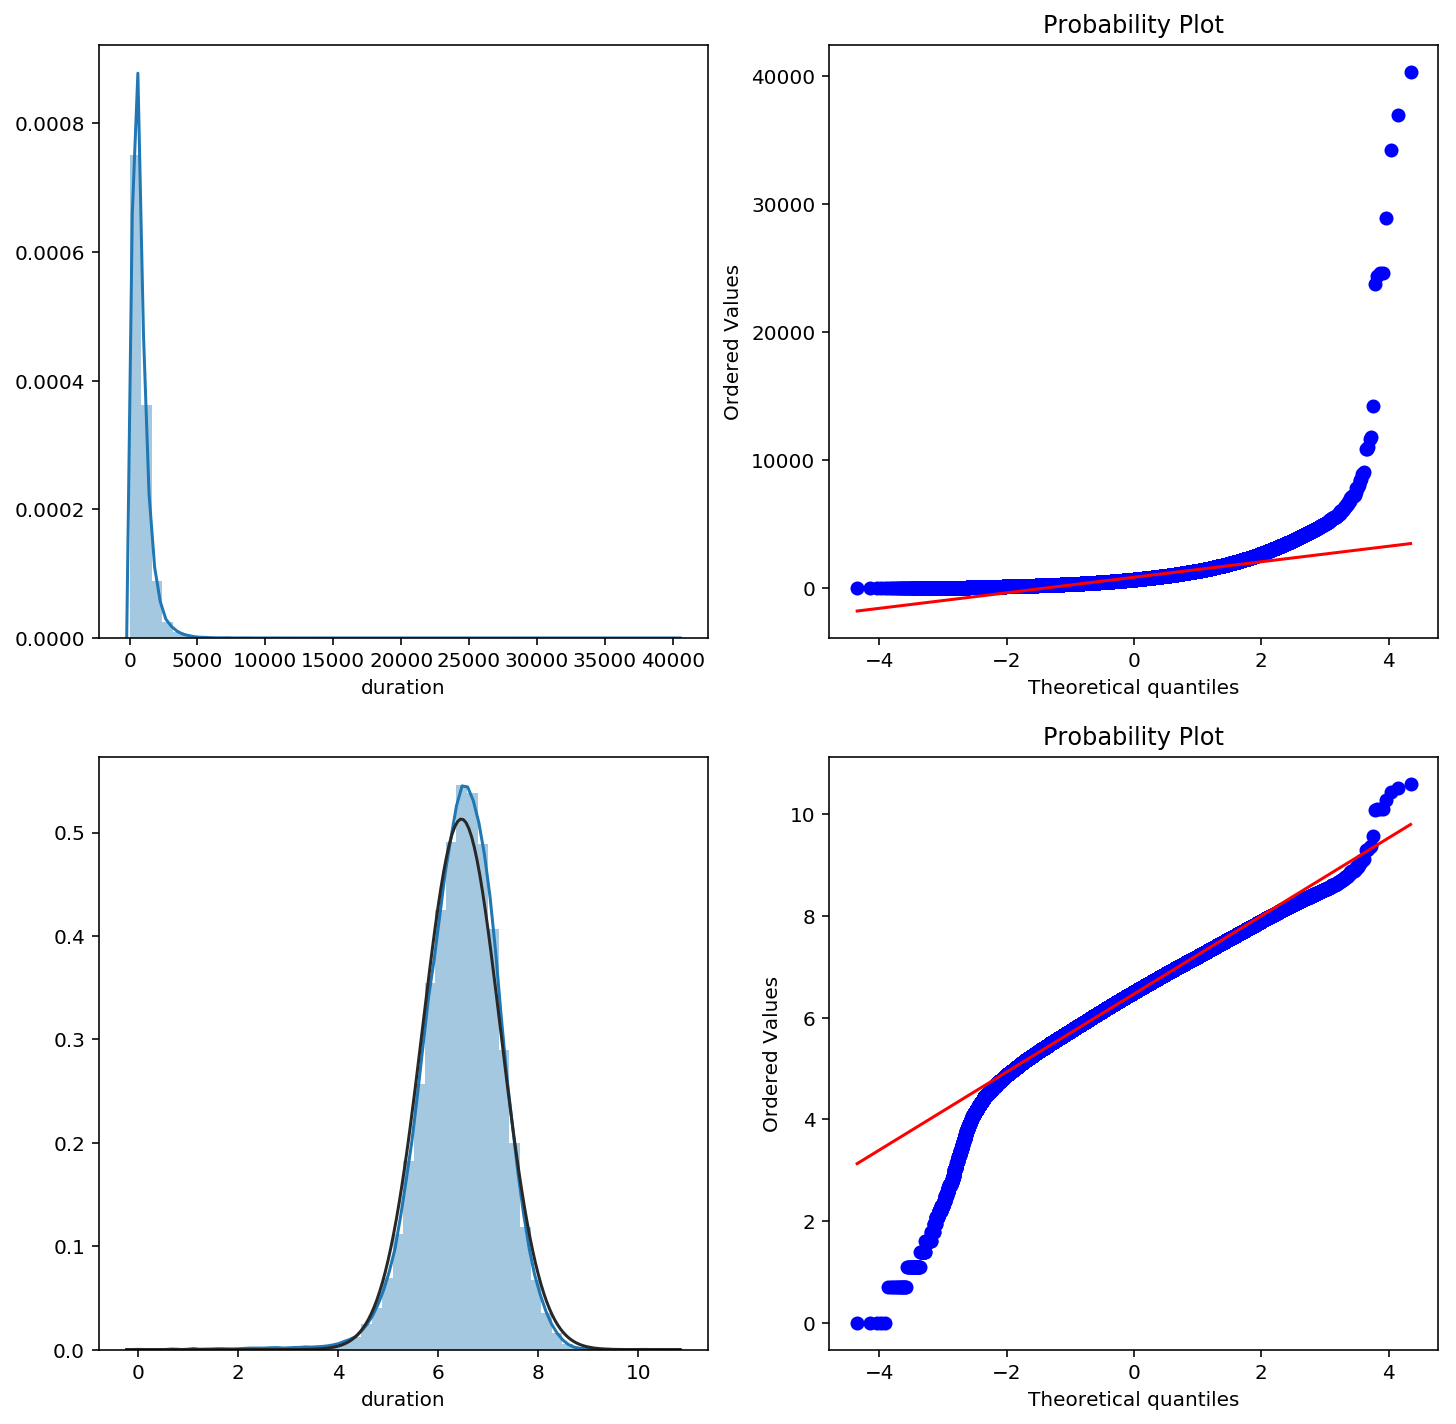

In [117]:
# Check Normality with histogram & QQ plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
sns.distplot(train["duration"], hist=True, kde=True, ax=axes[0,0])
stats.probplot(train["duration"], dist="norm", plot=axes[0,1])

log_duration = np.log(train["duration"])
sns.distplot(log_duration, hist=True, kde=True, fit=norm, ax=axes[1,0], label="log(duration)")
stats.probplot(log_duration, dist="norm", plot=axes[1,1])

# Check Normality with skewness & kurtosis
# Skewness = measure of symmetry (for Normal distribution = 0)
# Kurtosis = measure of heavy/light-tailed-ness (for Normal distribution = 0)
np.round(train["duration"].skew(),3) # durations are skewed right since min duration = 0
np.round(train["duration"].kurt(),3) # very heavy tailed distribution

np.round(log_duration.skew(),3) # almost symmetric
np.round(log_duration.kurt(),3) # very close to ideal value of 0; tails are slightly heavy


In [118]:
# Replace duration with log(duration)
train["log_duration"] = log_duration
train.head()

,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,log_duration
row_id,,,,,,,
3839371,-73.999504,40.728546,-73.940109,40.751213,1428134697,1367,7.220374
9098948,-73.987045,40.736526,-73.987503,40.747917,1441895559,518,6.249975
9903234,-73.985573,40.746094,-73.981079,40.720787,1443923755,934,6.839476
11598180,-73.793564,40.644791,-74.014565,40.708347,1448061696,3978,8.288534
591182,-73.987457,40.718502,-74.009727,40.722401,1422764086,602,6.400257


<a id="explore_time"/>

## Explore time covariate

Start timestamps are given in Unix epoch seconds. These values can be converted to components of UTC dates & times. These components are added to the training set as new features. From the plots below, there doesn't appear to be a strong correlation between duration and any of the components of trip start time other than "hour". Trips starting around 12pm and 4pm take slightly less time than those starting early in the morning or late in the night. Also, trips in 2016 seem to have slightly shorter duration than those in 2015.

In [119]:
# split timestamp into components
utcdt = pd.to_datetime(train['start_timestamp'], unit='s')

train["year"] = utcdt.dt.year
train["month"] = utcdt.dt.month
train["dayofweek"] = utcdt.dt.dayofweek
train["dayofmonth"] = utcdt.dt.day
train["dayofyear"] = utcdt.dt.dayofyear
train["hour"] = utcdt.dt.hour
train["minute"] = utcdt.dt.minute

train.head()


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,log_duration,year,month,dayofweek,dayofmonth,dayofyear,hour,minute
row_id,,,,,,,,,,,,,,
3839371,-73.999504,40.728546,-73.940109,40.751213,1428134697,1367,7.220374,2015,4,5,4,94,8,4
9098948,-73.987045,40.736526,-73.987503,40.747917,1441895559,518,6.249975,2015,9,3,10,253,14,32
9903234,-73.985573,40.746094,-73.981079,40.720787,1443923755,934,6.839476,2015,10,6,4,277,1,55
11598180,-73.793564,40.644791,-74.014565,40.708347,1448061696,3978,8.288534,2015,11,4,20,324,23,21
591182,-73.987457,40.718502,-74.009727,40.722401,1422764086,602,6.400257,2015,2,6,1,32,4,14


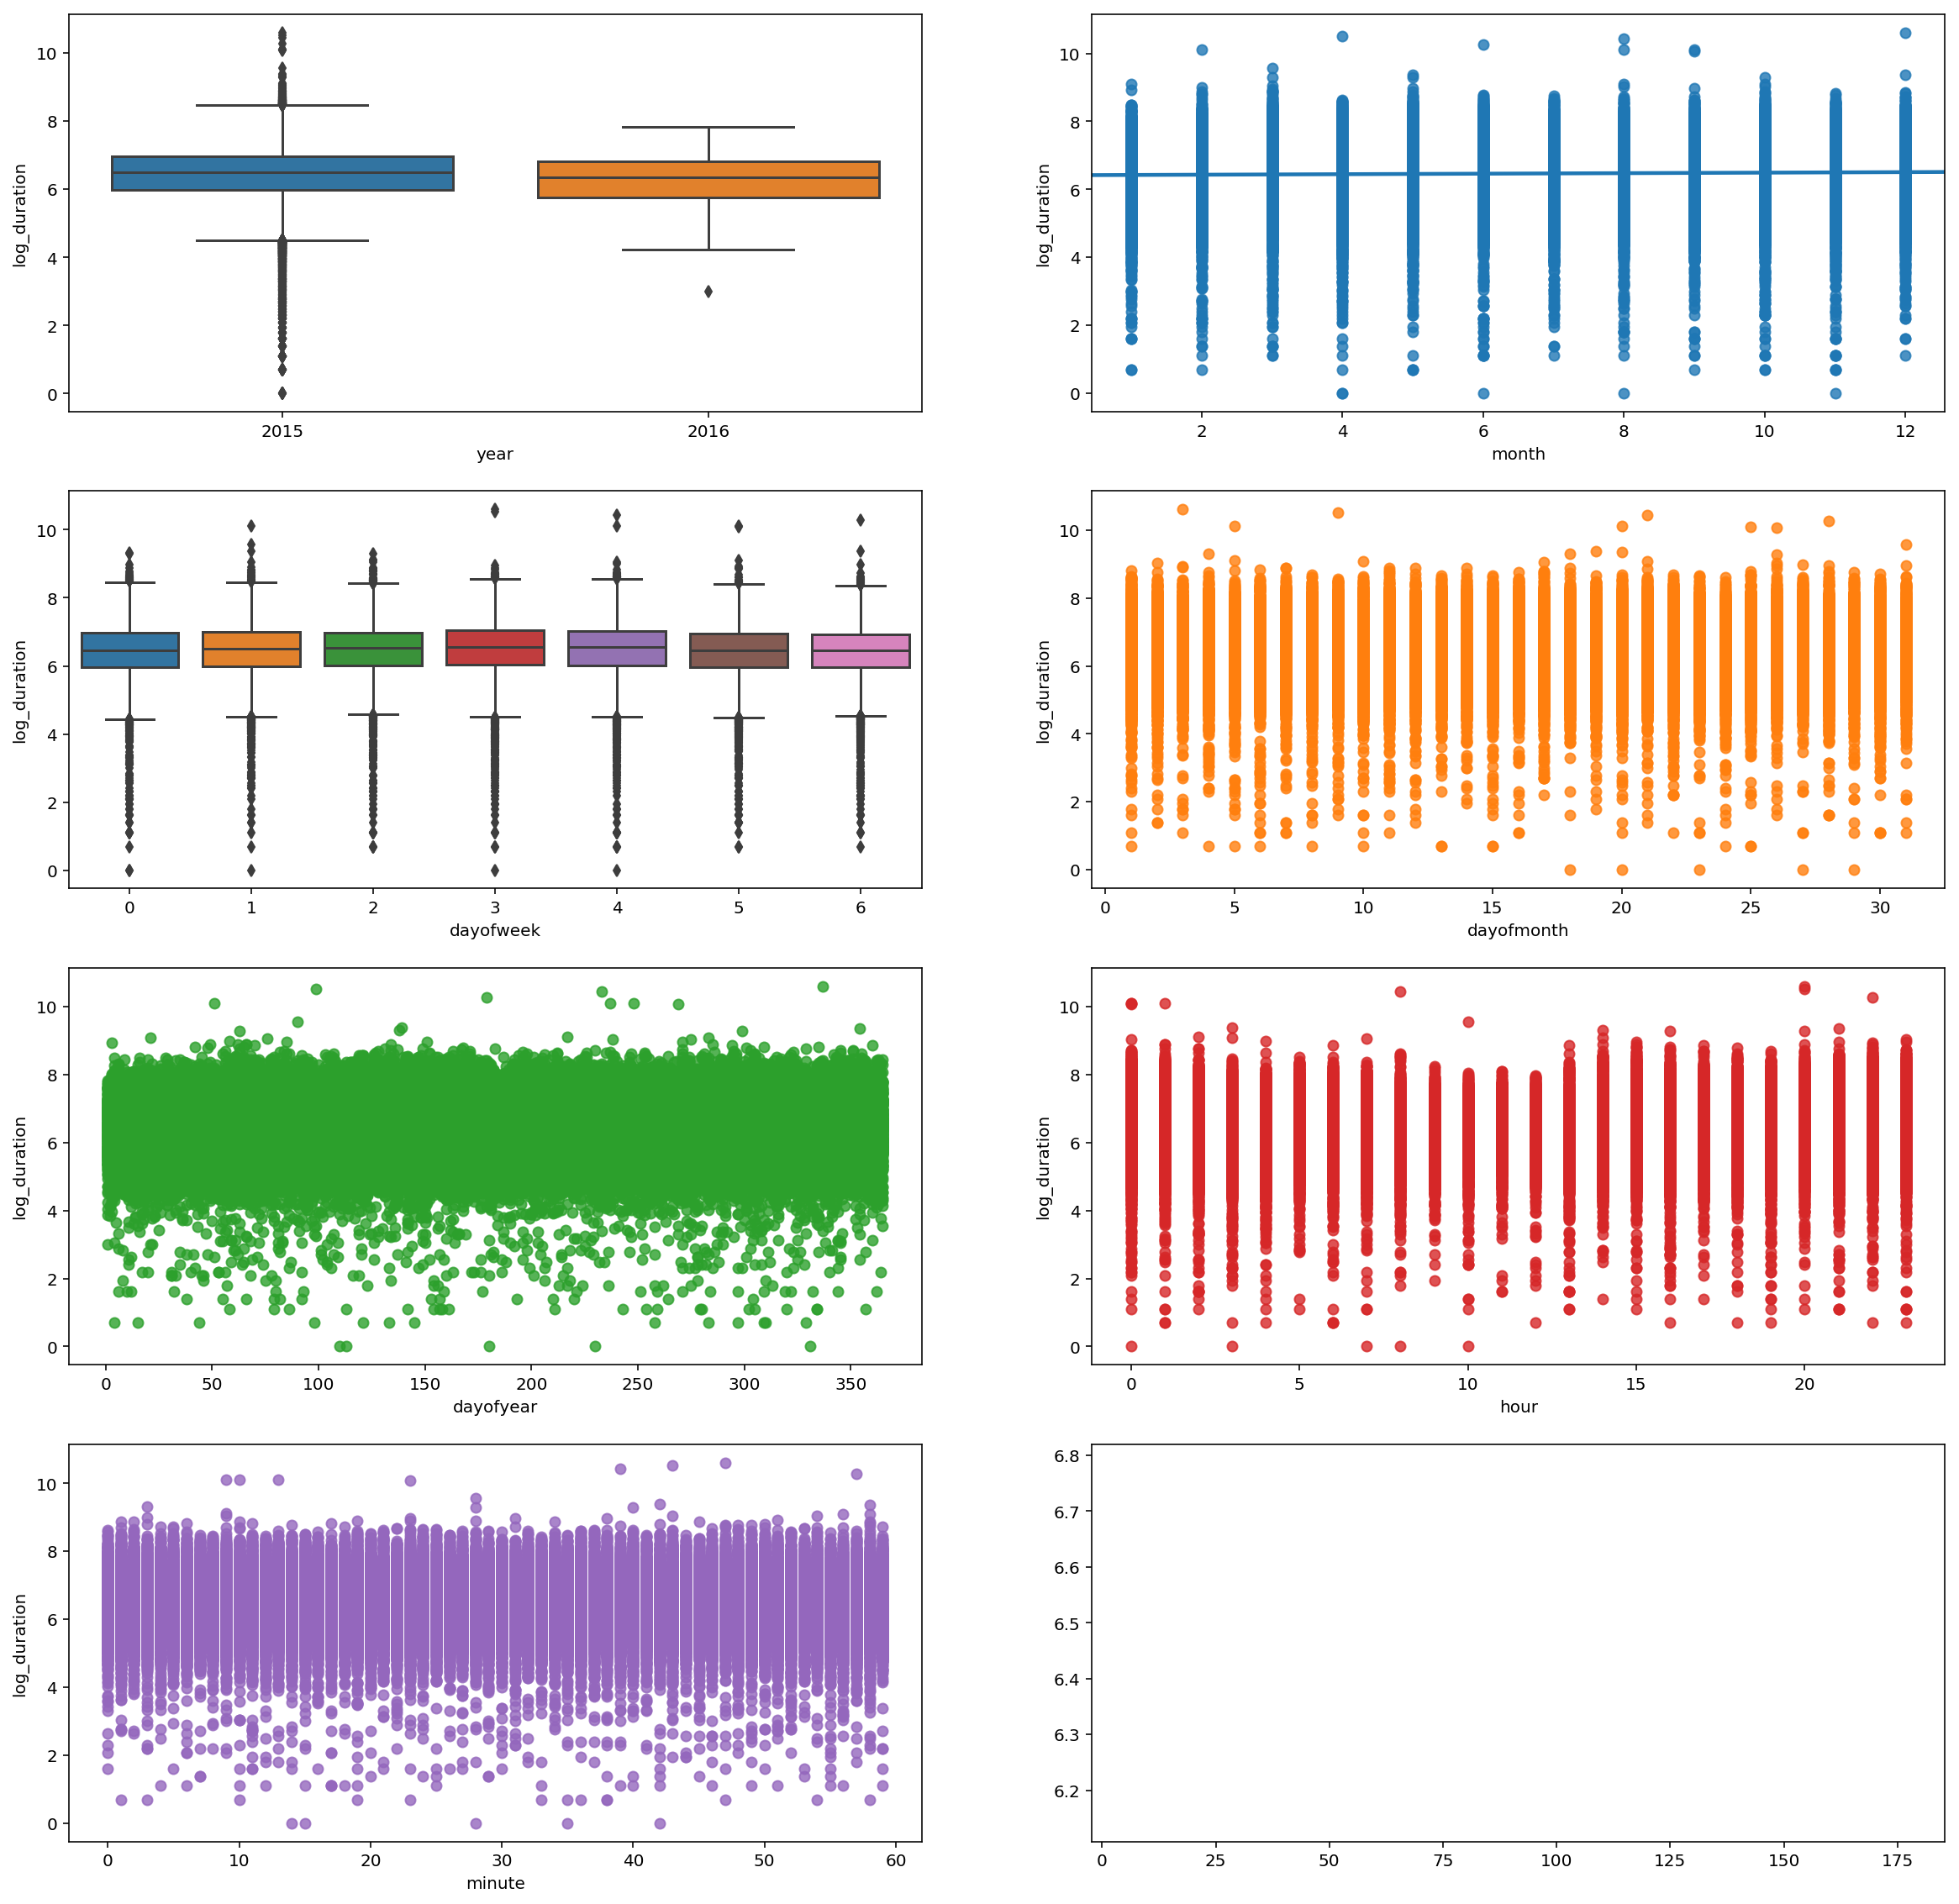

In [120]:
# Explore relationship between log(duration) & start time components. 
# Using duration in the original scale makes the plot diffcult to interpret due to the large scale of the duration values
fig, axes = plt.subplots(4, 2, figsize=(20,20))

sns.boxplot(x=train["year"], y=train["log_duration"], ax=axes[0,0])
sns.regplot(x=train["month"], y=train["log_duration"], ax=axes[0,1])

sns.boxplot(x=train["dayofweek"], y=train["log_duration"], ax=axes[1,0])
sns.regplot(x=train["dayofmonth"], y=train["log_duration"], fit_reg=False, ax=axes[1,1])

sns.regplot(x=train["dayofyear"], y=train["log_duration"], fit_reg=False, ax=axes[2,0])
sns.regplot(x=train["hour"], y=train["log_duration"], fit_reg=False, ax=axes[2,1])

sns.regplot(x=train["minute"], y=train["log_duration"], fit_reg=False, ax=axes[3,0])


<a id="explore_location"/>

## Explore location covariates

The given longitude & latitude coordinates have a precision of 6 decimal places. This is sub-meter resolution an sis too specific. In order to generalize from this dataset, it is better to reduce precision and consider neighborhoods within 100m of original location instead of the original location itself. This is done by rounding up coordinates to 3 decimal places.

In [121]:
# Create unique locations
start = train["start_lng"].map(str) + ',' + train["start_lat"].map(str)
end = train["end_lng"].map(str) + ',' + train["end_lat"].map(str)

# Do locations occur more than once?
start.value_counts().head(10)
end.value_counts().head(10)


-73.948639,40.7449                       3
-73.870758,40.773635999999996            3
-73.870964,40.773724                     3
-73.781876,40.644707000000004            3
-73.870972,40.773739                     3
-73.991341,40.750229                     3
-74.001442,40.730942                     3
-73.78220400000001,40.6446               3
-73.99408000000001,40.751098999999996    3
-73.98734300000001,40.722401             3
dtype: int64

-73.971947,40.786491             3
-73.948639,40.7449               3
-73.99137900000001,40.750198     3
-74.002716,40.760616             2
-73.962997,40.775028000000006    2
-73.86500500000001,40.770493     2
-73.993462,40.757133             2
-73.979202,40.75124              2
-73.87278,40.774307              2
-73.872795,40.774281             2
dtype: int64

In [122]:
# reduce precision of start and end location and consider only a neighborhood of 100m around original location
train["start_lng"] = np.round(train["start_lng"], 3)
train["start_lat"] = np.round(train["start_lat"], 3)
train["end_lng"] = np.round(train["end_lng"], 3)
train["end_lat"] = np.round(train["end_lat"], 3)

train.head() # verify rounding occured as expected

# Re-create unique locations
start = train["start_lng"].map(str) + ',' + train["start_lat"].map(str)
end = train["end_lng"].map(str) + ',' + train["end_lat"].map(str)

# Now see how often these "neighborhoods" occur
train["start_lng"].value_counts().head(10)
train["start_lat"].value_counts().head(10)
train["end_lng"].value_counts().head(10)
train["end_lat"].value_counts().head(10)

start.value_counts().head()
end.value_counts().head()


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,log_duration,year,month,dayofweek,dayofmonth,dayofyear,hour,minute
row_id,,,,,,,,,,,,,,
3839371,-74.000,40.729,-73.940,40.751,1428134697,1367,7.220374,2015,4,5,4,94,8,4
9098948,-73.987,40.737,-73.988,40.748,1441895559,518,6.249975,2015,9,3,10,253,14,32
9903234,-73.986,40.746,-73.981,40.721,1443923755,934,6.839476,2015,10,6,4,277,1,55
11598180,-73.794,40.645,-74.015,40.708,1448061696,3978,8.288534,2015,11,4,20,324,23,21
591182,-73.987,40.719,-74.010,40.722,1422764086,602,6.400257,2015,2,6,1,32,4,14


-73.982    3352
-73.991    2665
-73.990    2576
-73.981    2499
-73.989    2444
-73.992    2433
-73.978    2394
-73.988    2385
-73.987    2378
-73.983    2353
Name: start_lng, dtype: int64

40.750    2422
40.774    2355
40.756    2192
40.751    2188
40.764    2176
40.762    2135
40.763    1937
40.757    1876
40.752    1856
40.759    1845
Name: start_lat, dtype: int64

-73.982    2695
-73.991    2589
-73.979    2361
-73.978    2300
-73.983    2254
-73.981    2239
-73.990    2224
-73.985    2208
-73.992    2172
-73.980    2113
Name: end_lng, dtype: int64

40.750    2357
40.756    2094
40.761    1915
40.762    1912
40.764    1882
40.751    1880
40.757    1804
40.758    1779
40.763    1774
40.759    1756
Name: end_lat, dtype: int64

-73.994,40.751    519
-73.991,40.75     499
-73.782,40.645    497
-73.873,40.774    448
-73.871,40.774    432
dtype: int64

-73.991,40.75     504
-73.992,40.749    381
-73.995,40.75     351
-73.991,40.751    288
-73.871,40.774    204
dtype: int64

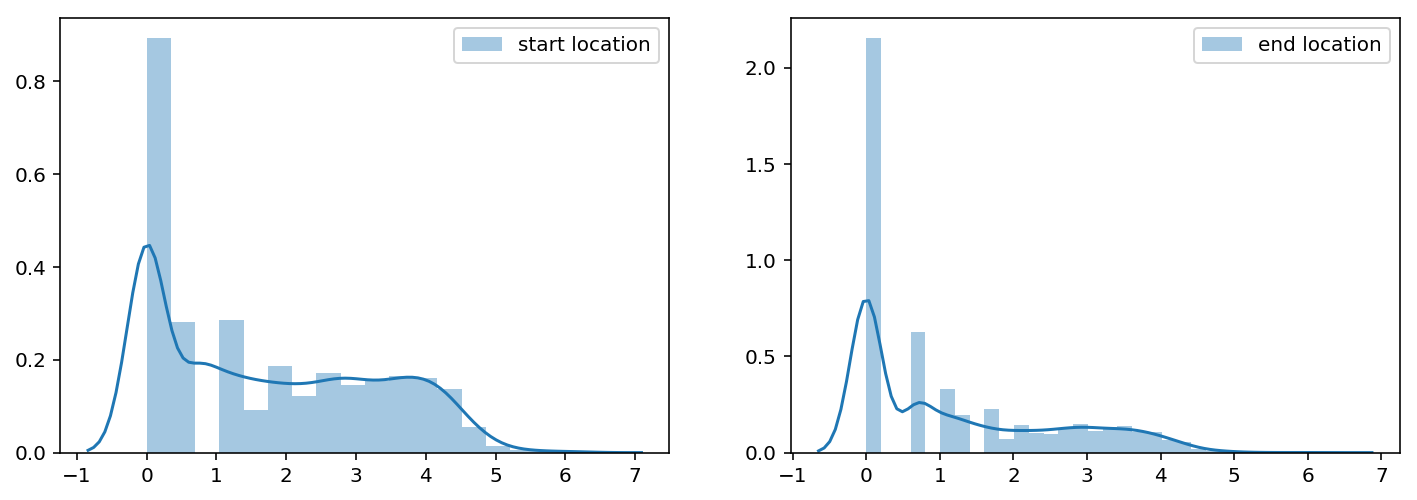

In [123]:
# Histogram of log(location frequency)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.distplot(np.log(start.value_counts()), ax=axes[0], label="start location")
sns.distplot(np.log(end.value_counts()), ax=axes[1], label="end location")

axes[0].legend()
axes[1].legend()


In [124]:
# Calculate Haversine distance between start & end neighborhoods
# This will be a key feature/covariate in the model
# NOTE: this is likely to be an underestimate of the actual trip distance
def calc_dist(x):
    dist = haversine((x["start_lat"], x["start_lng"]), (x["end_lat"], x["end_lng"]), miles=True)
    dist = np.round(dist, 2)
    return dist

# Distance between points
train["distance"] = train.apply(calc_dist, axis=1)
train.head()


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,log_duration,year,month,dayofweek,dayofmonth,dayofyear,hour,minute,distance
row_id,,,,,,,,,,,,,,,
3839371,-74.000,40.729,-73.940,40.751,1428134697,1367,7.220374,2015,4,5,4,94,8,4,3.49
9098948,-73.987,40.737,-73.988,40.748,1441895559,518,6.249975,2015,9,3,10,253,14,32,0.76
9903234,-73.986,40.746,-73.981,40.721,1443923755,934,6.839476,2015,10,6,4,277,1,55,1.75
11598180,-73.794,40.645,-74.015,40.708,1448061696,3978,8.288534,2015,11,4,20,324,23,21,12.37
591182,-73.987,40.719,-74.010,40.722,1422764086,602,6.400257,2015,2,6,1,32,4,14,1.22


The plot below suggests that there is a strong relationship between duration & distance with duration increasing with distance

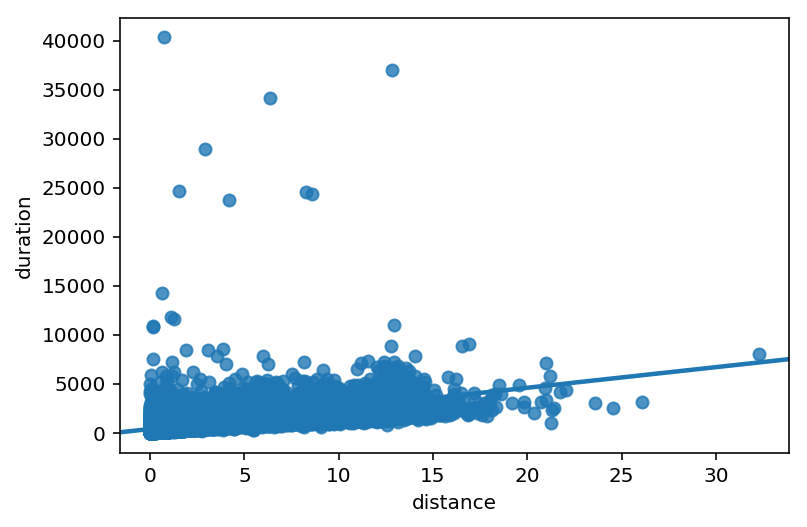

In [125]:
sns.regplot(x=train["distance"], y=train["duration"], fit_reg=True)


<a id="linear_regression"/>

## Linear Regression Model


In [126]:
# Split training set into train & validation sets for model development

y = train["log_duration"] # Use log-transformed duration for Linear regression since its distribution is almost Normal
X = train.drop(["start_timestamp", "duration", "log_duration"], axis=1)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, shuffle=True)

X_train.shape
X_validation.shape
y_train.shape
y_validation.shape

# Build linear regression model based on single train/validation split of training set data
# This model will be used to predict duration for test data
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_validation)


/usr/lib64/python3.4/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(70000, 12)

(30000, 12)

(70000,)

(30000,)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Mean absolute error (LR):  0.433448616435
Regression coefficients:  [ -2.79039678e+00   1.63458281e+00  -1.73316438e+00  -6.52407758e-01
  -9.39148824e-02   3.76875437e-01  -3.97736514e-03   1.18984784e-02
  -1.22193188e-02   4.82341226e-03  -1.70695130e-04   2.41756284e-01]


[Text(0,0,'start_lng'),
 Text(0,0,'start_lat'),
 Text(0,0,'end_lng'),
 Text(0,0,'end_lat'),
 Text(0,0,'year'),
 Text(0,0,'month'),
 Text(0,0,'dayofweek'),
 Text(0,0,'dayofmonth'),
 Text(0,0,'dayofyear'),
 Text(0,0,'hour'),
 Text(0,0,'minute'),
 Text(0,0,'distance')]

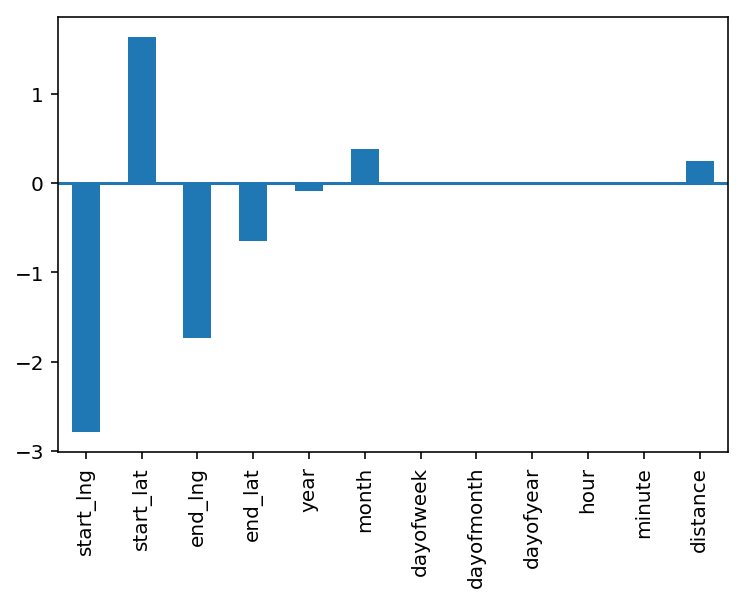

In [127]:
# Linear Regression MAE
lr_MAE = mean_absolute_error(y_validation, lr_pred)
print("Mean absolute error (LR): ", lr_MAE)

# Linear Regression feature weights
print("Regression coefficients: ", lr.coef_)

lr_coef = pd.DataFrame()
lr_coef["Covariate"] = X_train.columns.tolist()
lr_coef["Coefficient"] = lr.coef_

ax = lr_coef["Coefficient"].plot.bar()
ax.set_xticklabels(lr_coef["Covariate"])
plt.axhline(0)


<a id="gradient_boosted_regression"/>

## Gradient Boosted Regression Model

In [128]:
y = train["duration"] # Use untransformed duration since there are distributional assumptions about it
X = train.drop(["start_timestamp", "duration", "log_duration"], axis=1)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, shuffle=True)

# Build GB model based on single train/validation split of training data
# This model will be used to generate predicted values for test data
gbr = ensemble.GradientBoostingRegressor() # default parameters are sufficient
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_validation)


/usr/lib64/python3.4/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

Mean absolute error (GBR):  236.854467539


[Text(0,0,'start_lng'),
 Text(0,0,'start_lat'),
 Text(0,0,'end_lng'),
 Text(0,0,'end_lat'),
 Text(0,0,'year'),
 Text(0,0,'month'),
 Text(0,0,'dayofweek'),
 Text(0,0,'dayofmonth'),
 Text(0,0,'dayofyear'),
 Text(0,0,'hour'),
 Text(0,0,'minute'),
 Text(0,0,'distance')]

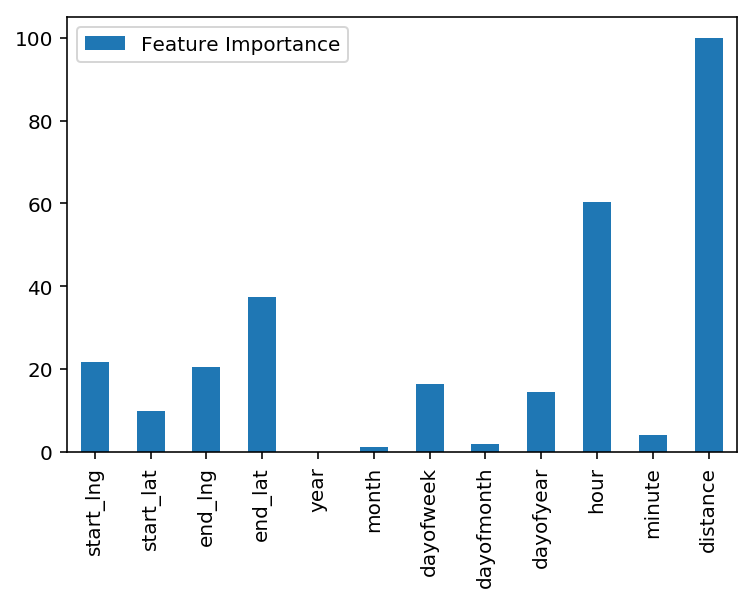

In [129]:
# GB MAE
gbr_MAE = mean_absolute_error(y_validation, gbr_pred)
print("Mean absolute error (GBR): ", gbr_MAE)

# GB feature importance
gbr_feature_importance = pd.DataFrame()
gbr_feature_importance["Feature Importance"] = 100*gbr.feature_importances_/max(gbr.feature_importances_)
gbr_feature_importance["Covariate"] = X_train.columns.tolist()

ax = gbr_feature_importance.plot.bar()
ax.set_xticklabels(gbr_feature_importance["Covariate"])


In [130]:
# Calculate GB MAE for 5 different train/test splits of data (5-fold cross-validation)
gb_scores = cross_val_score(gbr, X_train, y_train, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=2)
print(gb_scores)
print("Avg GB MAE =", np.round(np.mean(gb_scores),3))


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   3.1s
[CV] ................................................. , total=   3.2s
[CV] ................................................. , total=   3.3s
[CV] ................................................. , total=   3.3s
[CV] ................................................. , total=   3.3s


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


[-237.54628281 -238.07069464 -244.11164505 -238.64410882 -237.21515856]
Avg GB MAE = -239.118


<a id="random_forest_regression"/>

## Random Forest Regression Model

In [131]:
# Build RF model based on single train/validation split of training data
# This model will be used to generate predicted values for test data
rfr = ensemble.RandomForestRegressor(n_estimators=100, max_features=4) # max_features = n_features/3 per ISLR
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_validation)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Mean absolute error (RFR):  218.588884


[Text(0,0,'start_lng'),
 Text(0,0,'start_lat'),
 Text(0,0,'end_lng'),
 Text(0,0,'end_lat'),
 Text(0,0,'year'),
 Text(0,0,'month'),
 Text(0,0,'dayofweek'),
 Text(0,0,'dayofmonth'),
 Text(0,0,'dayofyear'),
 Text(0,0,'hour'),
 Text(0,0,'minute'),
 Text(0,0,'distance')]

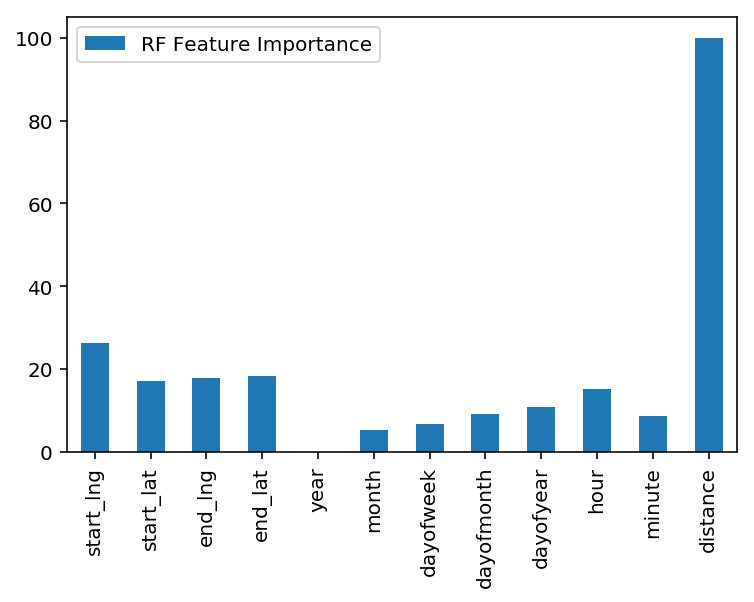

In [132]:
# RF MAE
rfr_MAE = mean_absolute_error(y_validation, rfr_pred)
print("Mean absolute error (RFR): ", rfr_MAE)

# RF feature importance
rf_feature_importance = pd.DataFrame()
rf_feature_importance["RF Feature Importance"] = 100*rfr.feature_importances_/max(rfr.feature_importances_)
rf_feature_importance["Covariate"] = X_train.columns.tolist()

ax = rf_feature_importance.plot.bar()
ax.set_xticklabels(rf_feature_importance["Covariate"])


In [133]:
# Calculate RF MAE for 5 different train/test splits of data (5-fold cross-validation)
rf_scores = cross_val_score(rfr, X_train, y_train, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=2)
print(rf_scores)
print("Avg RF MAE =", np.round(np.mean(rf_scores),3))


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  13.4s
[CV] ................................................. , total=  13.5s
[CV] ................................................. , total=  13.4s
[CV] ................................................. , total=  13.5s
[CV] ................................................. , total=  13.5s


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.5s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.6s finished


[-221.61488929 -222.11786214 -225.93574071 -222.54539    -220.35997286]
Avg RF MAE = -222.515


## Prediction test duration with Random Forests Model

Random Forests model shows lowest mean aboslute error (MAE) compared to the the Gradient Boosted Model. Both ensembl models are better than the Linear Regression model (when all 3 are run on log(duration) as response. So we will use the Random Forests model to predict duration for the test dataset.


<a id="prepare_test_dataset"/>

## Prepare test dataset

In [141]:
# Make test dataset features the same as training dataset

test.head()

# Reduce precision of start and end location and consider only a neighborhood of 100m around original location
test["start_lng"] = np.round(test["start_lng"], 3)
test["start_lat"] = np.round(test["start_lat"], 3)
test["end_lng"] = np.round(test["end_lng"], 3)
test["end_lat"] = np.round(test["end_lat"], 3)

# Split timestamp into components
utcdt = pd.to_datetime(test['start_timestamp'], unit='s')

test["year"] = utcdt.dt.year
test["month"] = utcdt.dt.month
test["dayofweek"] = utcdt.dt.dayofweek
test["dayofmonth"] = utcdt.dt.day
test["dayofyear"] = utcdt.dt.dayofyear
test["hour"] = utcdt.dt.hour
test["minute"] = utcdt.dt.minute

test = test.drop(["start_timestamp"], axis=1)

# Add distance between points
test["distance"] = test.apply(calc_dist, axis=1)

test.head()


,start_lng,start_lat,end_lng,end_lat,start_timestamp
row_id,,,,,
0,-73.993111,40.724289,-74.000977,40.735222,1422173589
1,-73.971924,40.762749,-73.965698,40.771427,1420567340
2,-73.953247,40.765816,-73.952843,40.772453,1420567343
3,-73.986618,40.739353,-73.949158,40.805161,1420103336
4,-73.968864,40.757317,-73.982521,40.771305,1420690180


,start_lng,start_lat,end_lng,end_lat,year,month,dayofweek,dayofmonth,dayofyear,hour,minute,distance
row_id,,,,,,,,,,,,
0,-73.993,40.724,-74.001,40.735,2015,1,6,25,25,8,13,0.87
1,-73.972,40.763,-73.966,40.771,2015,1,1,6,6,18,2,0.64
2,-73.953,40.766,-73.953,40.772,2015,1,1,6,6,18,2,0.41
3,-73.987,40.739,-73.949,40.805,2015,1,3,1,1,9,8,4.97
4,-73.969,40.757,-73.983,40.771,2015,1,3,8,8,4,9,1.21


<a id="predict_test_dataset"/>

## Predict duration for test dataset

In [147]:
# Predict duration for test data set and export to file
test_duration_pred = pd.DataFrame()
test_duration_pred["rowid"] = test.index
test_duration_pred["duration"] = rfr.predict(test)
test_duration_pred.to_csv("duration.csv", sep=',', index=False)


In [148]:
test_duration_pred.to_csv("duration.csv", sep=',', index=False)

In [160]:
# Time to predict duration for a single record in test data (proxy for real-time prediction)
t = test[:2]
%timeit rfr.predict(t)


5.23 ms ± 39.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
